두개의 스트림이 있고, shapebiased는 따로 먼저 학습이 진행되어야 한다.

shapebiased에서 사용할 데이터로더를 하나 만들고..
그리고 통합해서 내뱉는 데이터로더를 하나 더 만들어서 사용하자.



In [12]:
import os
import pickle
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [3]:
LANDMARK_MAP = ['left_collar',
 'right_collar',
 'left_sleeve',
 'right_sleeve',
 'left_waistline',
 'right_waistline',
 'left_hem',
 'right_hem']
IMG_DIR = '/media/jaeho/SSD/datasets/deepfashion/img-001/'

## 데이터셋을 만들자

In [89]:
class ShapeDataset(Dataset):
    def __init__(self, data_path):
        super(ShapeDataset, self).__init__()
        
        with open(data_path, 'rb') as f:
            raw_dict = pickle.load(f)
        self.raw_data = list(raw_dict.items())
    
    def __len__(self):
        return len(self.raw_data)
    
    def _make_visibility(self, landmark_info):
        visibility = []
        for lm in LANDMARK_MAP:
            if lm in landmark_info:
                visibility.append(1 if landmark_info[lm][0] == 0 else 0)
            else :
                visibility.append(0)
        return visibility
    
    # 로더에서 이걸 만드는게 나을까? 아니면 그냥 미리 만들어두는게 나을까
    def _make_landmark(self, img_size, landmark_info):
        height, width = img_size
        heatmap_size = img_size # 이걸 다르게?
        visibility = self._make_visibility(landmark_info)
        
        nof_joints = len(LANDMARK_MAP)
        joints_vis =np.array([[x] for x in visibility])
        
        target = np.zeros((nof_joints, width, height), dtype=np.float32)
        target_weight = np.ones((nof_joints, 1), dtype=np.float32)
        
        joints = [landmark_info[x][1:] if x in landmark_info else [0, 0] for x in LANDMARK_MAP]
        joints = np.array(joints, dtype=np.float32)
        
        heatmap_sigma = 3
        tmp_size = heatmap_sigma * 3
        
        for joint_id in range(nof_joints):
            feat_stride = np.asarray(img_size) / np.asarray(heatmap_size)  # 이게 같으면 늘 1일텐데
            mu_x = int(joints[joint_id][0] / feat_stride[0] + 0.5)
            mu_y = int(joints[joint_id][1] / feat_stride[1] + 0.5)
            
            ul = [int(mu_x - tmp_size), int(mu_y - tmp_size)]
            br = [int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)]
            
            if ul[0] >= heatmap_size[0] or ul[1] >= heatmap_size[1] or br[0] < 0 or br[1] < 0:
                target_weight[joint_id] = 0
                continue
            
            # generate gaussian
            size = 2 * tmp_size + 1
            x = np.arange(0, size, 1, np.float32)
            y = x[:, np.newaxis]
            x0 = y0 = size // 2
            
            # the gaussian is not normalized, we want the center value to equal 1
            g = np.exp(- ((x-x0) ** 2 + (y - y0) ** 2) / (2 * heatmap_sigma ** 2))            
            
            # usable gaussian range
            g_x = max(0, -ul[0]), min(br[0], heatmap_size[0]) - ul[0]
            g_y = max(0, -ul[1]), min(br[1], heatmap_size[1]) - ul[1]
            
            # image rnage
            img_x = max(0, ul[0]), min(br[0], heatmap_size[0])
            img_y = max(0, ul[1]), min(br[1], heatmap_size[1])

            v = target_weight[joint_id]

            if v > 0.5:
                target[joint_id][img_y[0] : img_y[1], img_x[0]:img_x[1]] = g[g_y[0]:g_y[1], g_x[0]:g_x[1]]
        return target, visibility
    
    def __getitem__(self, index):
        img_path, data_dict = self.raw_data[index]
        landmark_info = data_dict['landmark']
        
        img_path = os.path.join('/media/jaeho/SSD/datasets/deepfashion/img-001/', img_path)
        print(img_path)
        img = Image.open(img_path).convert("RGB")
        
        landmark, visibility = self._make_landmark(img.size, landmark_info)
        
        return img, landmark, visibility

In [90]:
test_dataset = ShapeDataset('/media/jaeho/SSD/datasets/deepfashion/preprocessed_data/preprocessed_data.pickle')

In [92]:
cnt = 0
for img, lm, vis in test_dataset:
    print(cnt)
    print(vis)
    cnt+=1
    if cnt == 6 :
        break

/media/jaeho/SSD/datasets/deepfashion/img-001/img/Sheer_Pleated-Front_Blouse/img_00000001.jpg
0
[1, 1, 1, 1, 0, 0, 1, 1]
/media/jaeho/SSD/datasets/deepfashion/img-001/img/Sheer_Pleated-Front_Blouse/img_00000002.jpg
1
[1, 1, 1, 1, 0, 0, 1, 1]
/media/jaeho/SSD/datasets/deepfashion/img-001/img/Sheer_Pleated-Front_Blouse/img_00000003.jpg
2
[1, 1, 1, 1, 0, 0, 1, 1]
/media/jaeho/SSD/datasets/deepfashion/img-001/img/Sheer_Pleated-Front_Blouse/img_00000004.jpg
3
[1, 1, 1, 1, 0, 0, 1, 1]
/media/jaeho/SSD/datasets/deepfashion/img-001/img/Sheer_Pleated-Front_Blouse/img_00000005.jpg
4
[0, 1, 1, 0, 0, 0, 1, 1]
/media/jaeho/SSD/datasets/deepfashion/img-001/img/Sheer_Pleated-Front_Blouse/img_00000006.jpg
5
[1, 1, 1, 1, 0, 0, 1, 1]


In [93]:
import matplotlib.pyplot as plt

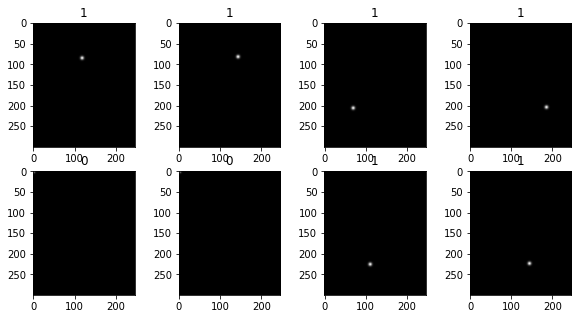

In [94]:
plt.figure(figsize=(10, 5))
for idx, t in enumerate(lm):
    plt.subplot(2, 4, idx+1)
    plt.title(vis[idx])
    plt.imshow(t, cmap='gray', vmin=0, vmax=1)
plt.show()

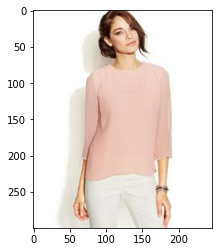

In [95]:
plt.imshow(img)
plt.show()

In [4]:
class TSDataset(Dataset):
    def __init__(self, data_path):
        super(TSDataset, self).__init__()
        with open(data_path, 'rb') as f:
            raw_dict = pickle.load(f)
        self.raw_data = list(raw_dict.items())
        
    def __len__(self):
        return len(self.raw_data)
    
    def _make_visibility(self, landmark_info):
        visibility = []
        for lm in LANDMARK_MAP:
            if lm in landmark_info:
                visibility.append(1 if landmark_info[lm][0] == 0 else 0)
            else :
                visibility.append(0)
        return visibility
    
    def _make_landmark(self, img_size, landmark_info):
        height, width = img_size
        heatmap_size = img_size # 이걸 다르게?
        visibility = self._make_visibility(landmark_info)
        
        nof_joints = len(LANDMARK_MAP)
        joints_vis =np.array([[x] for x in visibility])
        
        target = np.zeros((nof_joints, width, height), dtype=np.float32)
        target_weight = np.ones((nof_joints, 1), dtype=np.float32)
        
        joints = [landmark_info[x][1:] if x in landmark_info else [0, 0] for x in LANDMARK_MAP]
        joints = np.array(joints, dtype=np.float32)
        
        heatmap_sigma = 3
        tmp_size = heatmap_sigma * 3
        
        for joint_id in range(nof_joints):
            feat_stride = np.asarray(img_size) / np.asarray(heatmap_size)  # 이게 같으면 늘 1일텐데
            mu_x = int(joints[joint_id][0] / feat_stride[0] + 0.5)
            mu_y = int(joints[joint_id][1] / feat_stride[1] + 0.5)
            
            ul = [int(mu_x - tmp_size), int(mu_y - tmp_size)]
            br = [int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)]
            
            if ul[0] >= heatmap_size[0] or ul[1] >= heatmap_size[1] or br[0] < 0 or br[1] < 0:
                target_weight[joint_id] = 0
                continue
            
            # generate gaussian
            size = 2 * tmp_size + 1
            x = np.arange(0, size, 1, np.float32)
            y = x[:, np.newaxis]
            x0 = y0 = size // 2
            
            # the gaussian is not normalized, we want the center value to equal 1
            g = np.exp(- ((x-x0) ** 2 + (y - y0) ** 2) / (2 * heatmap_sigma ** 2))            
            
            # usable gaussian range
            g_x = max(0, -ul[0]), min(br[0], heatmap_size[0]) - ul[0]
            g_y = max(0, -ul[1]), min(br[1], heatmap_size[1]) - ul[1]
            
            # image rnage
            img_x = max(0, ul[0]), min(br[0], heatmap_size[0])
            img_y = max(0, ul[1]), min(br[1], heatmap_size[1])

            v = target_weight[joint_id]

            if v > 0.5:
                target[joint_id][img_y[0] : img_y[1], img_x[0]:img_x[1]] = g[g_y[0]:g_y[1], g_x[0]:g_x[1]]
        return target, visibility
    
    def __getitem__(self, index):
        # texture biased stream
        ## category, attribute
        # shape biased stream
        ## visibility, landmark location
        
        img_path, data_dict = self.raw_data[index]
        landmark_info = data_dict['landmark']
        
        img_path = os.path.join(IMG_DIR, img_path)
        img = Image.open(img_path).convert("RGB")
        landmark, visibility = self._make_landmark(img.size, landmark_info)
        
        category = F.one_hot(torch.LongTensor(data_dict['category']), 46)
        attribute = torch.Tensor([1 if x == 1 else 0 for x in data_dict['attr']])
        
        return img, category, attribute, visibility, landmark

In [5]:
data_path = '/media/jaeho/SSD/datasets/deepfashion/preprocessed_data/preprocessed_data.pickle'

In [6]:
ts_dataset = TSDataset(data_path)
# ts_dataloader = DataLoader(ts_dataset)

In [15]:
idx = 0
for img, cat, att, vis, lm in tqdm(ts_dataset):
    idx += 1

 69%|██████▉   | 199045/289222 [03:24<01:32, 972.58it/s] 


RuntimeError: Class values must be smaller than num_classes.

In [8]:
torch.where(cat[0])

(tensor([3]),)

In [9]:
cat.shape

torch.Size([1, 46])

In [137]:
torch.where(att)

(tensor([717, 818]),)

In [139]:
vis

[1, 1, 1, 1, 0, 0, 1, 1]

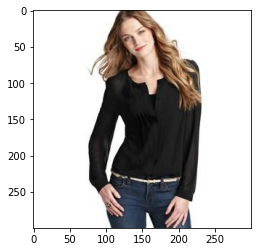

In [140]:
plt.imshow(img)
plt.show()

In [142]:
lm.shape

(8, 300, 300)

bbox crop은 해야하나?  
이건.... numpy crop이 있지 않을까